# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.0.2

In [1]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

digits = load_digits()
pca = PCA(0.99, whiten=True)
X = pca.fit_transform(digits.data)
y = digits.target
X.shape

(1797, 41)


## Actividad en clase

Usando el algoritmo **linearSVC**, haga lo siguiente:

- Particione el dataset en train/test con proporción **0.3** usando **muestreo estratificado** con respecto a y.
- Cree un clasificador **linearSVC** sobre datos estandarizados (standard scaler). 
- Entrene usando la particion de train con el método fit().
- Evalúe el modelo en la partición de testing usando **accuracy_score, classification_report y confusion_matrix_display**.
- Cuanto termine, me avisa para entregarle una **L (logrado)**.
- Recuerde que cada L es una décima más en la nota de la asignatura.
- Pueden trabajar de a dos.

***Tiene hasta el final de la clase.***


# Solución

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [8]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), LinearSVC())
clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])

In [9]:
from sklearn import metrics

y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9611111111111111


In [10]:
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        54
           1       0.95      0.95      0.95        55
           2       0.98      1.00      0.99        53
           3       0.93      0.96      0.95        55
           4       0.95      1.00      0.97        54
           5       0.96      0.95      0.95        55
           6       0.98      0.96      0.97        54
           7       1.00      1.00      1.00        54
           8       0.94      0.85      0.89        52
           9       0.96      0.94      0.95        54

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540



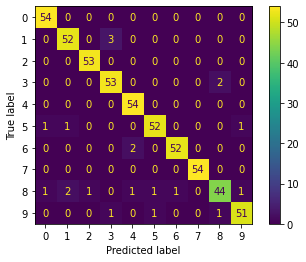

In [11]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()